# Coursera Capstone Project - The Battle of the Neighborhoods
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

In this project we will try to find the best area for a person to move on. Specifically, this report will be targeted to people interested in moving from **Azcapotzalco, Mexico City** to **Queretaro, Queretaro**, however it can be done anywhere.

Since there are a lot of neighbourhoods in Queretaro we will try to **segment them** into some areas. We will determine those areas by **the most common venues** in the neighbourhoods. We also need the **ones** from the person's residence so the areas can be compared.

We will use data science to generate the most promising area based on this criteria. The similarities between these areas will then be expressed so that the decision can be taken by the skateholders.

## Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decission are:
* most common venues in each neighbourhood
* distance between the neighbourhoods
* most common venues in the person's current neighbourhood.

Following data sources will be needed to extract/generate the required information:
* names and coordinates of the neighbourhoods will be obtained with 2 existing datasets.
* number of restaurants and their type and location in every neighbourhood will be obtained using **Foursquare API**

### Getting the neighbours
We need to get the names and geographical coordinates of the neighbours found in Queretaro and the ones of our current residence. We will also display them on a map to see their geographical location.

First we need to import the neccessary libraries.

In [1]:
import pandas as pd
import numpy as np
#from zipfile import ZipFile
#!pip install folium
import folium
import requests
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

This code was used to import the dataset. I commented it because it is already in the local storage.

In [2]:
#!wget -q -O 'iter_22xlsx20.zip' https://www.inegi.org.mx/contenidos/programas/ccpv/iter/zip/iter2020/iter_22csv20.zip
#zip = ZipFile('iter_22xlsx20.zip')
#zip.extractall()
#zip.printdir()

Then we read the csv file and store it into a dataframe.

In [3]:
df = pd.read_csv('ITER_22CSV20.csv');
df.head()

,ENTIDAD,NOM_ENT,MUN,NOM_MUN,LOC,NOM_LOC,LONGITUD,LATITUD,ALTITUD,POBTOT,...,VPH_CEL,VPH_INTER,VPH_STVP,VPH_SPMVPI,VPH_CVJ,VPH_SINRTV,VPH_SINLTC,VPH_SINCINT,VPH_SINTIC,TAMLOC
0,22,Querétaro,0,Total de la entidad Querétaro,0,Total de la Entidad,NaN,NaN,NaN,2368467,...,606978,430045,382086,183742,106431,22702,44358,208004,9228,*
1,22,Querétaro,0,Total de la entidad Querétaro,9998,Localidades de una vivienda,NaN,NaN,NaN,1878,...,310,106,116,30,22,75,83,273,48,*
2,22,Querétaro,0,Total de la entidad Querétaro,9999,Localidades de dos viviendas,NaN,NaN,NaN,971,...,189,53,63,19,14,77,88,209,52,*
3,22,Querétaro,1,Amealco de Bonfil,0,Total del Municipio,NaN,NaN,NaN,66841,...,12954,1926,3018,327,341,1708,3769,14205,1047,*
4,22,Querétaro,1,Amealco de Bonfil,1,Amealco de Bonfil,"100°08'39.102"" W","20°11'11.198"" N",2639.0,7953,...,1882,934,1032,208,157,68,142,979,16,6


We have to clean the data, first we create another dataframe with the required features, which are the borough, neighbourhood, latitude and longitude, and we change the name of the columns. Then, we select the rows where the borough is "Queretaro", finally we drop the rows where there are missing values and show the new dataframe.

In [4]:
neighbourhoods = df[['NOM_MUN','NOM_LOC','LONGITUD','LATITUD']]
neighbourhoods = neighbourhoods.rename(columns={'NOM_MUN': 'Borough','NOM_LOC': 'Neighbourhood', 'LONGITUD': 'Longitude', 'LATITUD': 'Latitude'})
neighbourhoods = neighbourhoods[neighbourhoods['Borough'].str.contains('Querétaro')]
neighbourhoods = neighbourhoods.dropna()
neighbourhoods.reset_index(inplace=True, drop=True)
print("The size of the dataframe is " + str(neighbourhoods.shape))
neighbourhoods.head(10)

The size of the dataframe is (143, 4)


,Borough,Neighbourhood,Longitude,Latitude
0,Querétaro,Santiago de Querétaro,"100°23'23.846"" W","20°35'36.208"" N"
1,Querétaro,Acequia Blanca,"100°28'03.115"" W","20°43'10.521"" N"
2,Querétaro,La Barreta,"100°30'18.638"" W","20°49'35.408"" N"
3,Querétaro,Buenavista,"100°28'08.942"" W","20°49'17.805"" N"
4,Querétaro,La Carbonera,"100°30'15.068"" W","20°48'23.382"" N"
5,Querétaro,Casa Blanca,"100°30'21.626"" W","20°45'07.262"" N"
6,Querétaro,Cerro de la Cruz,"100°29'56.678"" W","20°48'54.937"" N"
7,Querétaro,Cerro Colorado (El Colorado),"100°29'58.873"" W","20°45'41.251"" N"
8,Querétaro,Charape la Joya,"100°33'11.252"" W","20°47'48.682"" N"
9,Querétaro,Charape de los Pelones,"100°27'16.944"" W","20°55'11.160"" N"


The geographical coordinates need to be changed to the correct format so we can use them.

In [5]:
def conversion(old):
    direction = {'N':1, 'S':-1, 'E': 1, 'W':-1}
    new = old.replace(u'°',' ').replace('\'',' ').replace('"',' ')
    new = new.split()
    new_dir = new.pop()
    new.extend([0,0,0])
    return (int(new[0])+int(new[1])/60.0+float(new[2])/3600.0) * direction[new_dir]
i = 0
for row in neighbourhoods['Latitude']:
    newLatitude = conversion(str(neighbourhoods['Latitude'][i]))
    neighbourhoods['Latitude'][i] = newLatitude
    i = i+1
j = 0  
for row in neighbourhoods['Longitude']:
    newLongitude = conversion(str(neighbourhoods['Longitude'][j]))
    neighbourhoods['Longitude'][j] = newLongitude
    j = j+1
    
neighbourhoods.head(10)

,Borough,Neighbourhood,Longitude,Latitude
0,Querétaro,Santiago de Querétaro,-100.39,20.5934
1,Querétaro,Acequia Blanca,-100.468,20.7196
2,Querétaro,La Barreta,-100.505,20.8265
3,Querétaro,Buenavista,-100.469,20.8216
4,Querétaro,La Carbonera,-100.504,20.8065
5,Querétaro,Casa Blanca,-100.506,20.752
6,Querétaro,Cerro de la Cruz,-100.499,20.8153
7,Querétaro,Cerro Colorado (El Colorado),-100.5,20.7615
8,Querétaro,Charape la Joya,-100.553,20.7969
9,Querétaro,Charape de los Pelones,-100.455,20.9198


Let's now show the neighbourhoods in a folium map!

In [6]:
longitude = -100.39
latitude = 20.7
map_queretaro = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, borough, neighbourhood in zip(neighbourhoods['Latitude'], neighbourhoods['Longitude'], neighbourhoods['Borough'], neighbourhoods['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_queretaro)  
    
map_queretaro

We have to repeat the same steps with the Mexico City dataset to get the current residence (which is Azcapotzalco), then we show it in a map.

In [7]:
#!wget -q -O 'iter_09csv20.zip' https://www.inegi.org.mx/contenidos/programas/ccpv/iter/zip/iter2020/iter_09csv20.zip
#zip = ZipFile('iter_09csv20.zip')
#zip.extractall()
#zip.printdir()
df = pd.read_csv('ITER_09CSV20.csv');
df.head()
residence = df[['NOM_MUN','NOM_LOC','LONGITUD','LATITUD']]
residence = residence.rename(columns={'NOM_MUN': 'Borough','NOM_LOC': 'Neighbourhood', 'LONGITUD': 'Longitude', 'LATITUD': 'Latitude'})
residence = residence[residence['Borough'].str.contains('Azcapotzalco')]
residence = residence.dropna()
residence.reset_index(inplace=True, drop=True)

i = 0
for row in residence['Latitude']:
    newLatitude = conversion(str(residence['Latitude'][i]))
    residence['Latitude'][i] = newLatitude
    i = i+1
j = 0  
for row in residence['Longitude']:
    newLongitude = conversion(str(residence['Longitude'][j]))
    residence['Longitude'][j] = newLongitude
    j = j+1
    
residence.head(10)

longitude = -99.1844
latitude = 19.4841

map_residence = folium.Map(location=[latitude, longitude], zoom_start=13)

for lat, lng, borough, neighbourhood in zip(residence['Latitude'], residence['Longitude'], residence['Borough'], residence['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=25,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_residence)  
    
map_residence

### Foursquare
Now that we have our neighbourhoods, let's use Foursquare API to get info on venues in each neighborhood.

Foursquare credentials are defined in hidden cell bellow.

In [8]:
# The code was removed by Watson Studio for sharing.

Here we define a function that returns all nearby venues.

In [9]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

We then get all venues near each neighbourhood.

In [10]:
queretaro_venues = getNearbyVenues(names=neighbourhoods['Neighbourhood'],
                                   latitudes=neighbourhoods['Latitude'],
                                   longitudes=neighbourhoods['Longitude']
                                  )

Santiago de Querétaro
Acequia Blanca
La Barreta
Buenavista
La Carbonera
Casa Blanca
Cerro de la Cruz
Cerro Colorado (El Colorado)
Charape la Joya
Charape de los Pelones
La Estacada
Estancia de la Rochera
La Estancia de Palo Dulce
San Francisco de la Palma
La Gotera
El Herrero
Jofre
Jofrito
La Joya
Juriquilla
Loma del Chino
La Luz
Llano de la Rochera
Mompaní
La Monja
Montenegro
El Nabo
Ojo de Agua
La Palma
Palo Alto
El Patol
Pie de Gallo
El Pie
Pintillo
Pinto
Presa de Becerra
Presita de San Antonio
Corea
El Puertecito
Puerto de Aguirre
La Purísima
Rancho Largo
El Refugio
Rancho el Rincón
El Salitre
San Isidro Buenavista
San Isidro el Alto
San Isidro el Viejo
San José Buenavista
San José el Alto
San Miguelito
San Pedro Mártir
Santa Catarina
Santa María Magdalena
Santa Rosa Jáuregui
Santo Niño de Praga
La Solana
La Tinaja de la Estancia
Tlacote el Alto
Tlacote el Bajo
El Tránsito
La Versolilla
Santa María del Zapote
La Puerta de Santiaguillo
La Purísima
San Pedrito el Alto (El Obraje)
Cer

We need to make a one-hot encoding with the venues so that we can apply a machine learning algorithm.

In [11]:
queretaro_onehot = pd.get_dummies(queretaro_venues[['Venue Category']], prefix="", prefix_sep="")

queretaro_onehot['Neighborhood'] = queretaro_venues['Neighborhood'] 

fixed_columns = [queretaro_onehot.columns[-1]] + list(queretaro_onehot.columns[:-1])
queretaro_onehot = queretaro_onehot[fixed_columns]

print("The number of venues is " + str(queretaro_onehot.shape))
queretaro_onehot.head()

The number of venues is (892, 157)


,Neighborhood,Amphitheater,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,...,Taco Place,Tailor Shop,Tattoo Parlor,Tennis Court,Tex-Mex Restaurant,Theater,Track Stadium,Vegetarian / Vegan Restaurant,Wings Joint,Yoga Studio
0,Santiago de Querétaro,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Santiago de Querétaro,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,Santiago de Querétaro,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Santiago de Querétaro,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Santiago de Querétaro,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now we have to group the venues by neighbourhood.

In [12]:
queretaro_grouped = queretaro_onehot.groupby('Neighborhood').mean().reset_index()
queretaro_grouped

,Neighborhood,Amphitheater,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,...,Taco Place,Tailor Shop,Tattoo Parlor,Tennis Court,Tex-Mex Restaurant,Theater,Track Stadium,Vegetarian / Vegan Restaurant,Wings Joint,Yoga Studio
0,Acequia Blanca,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
1,Acueducto,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.333333,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
2,Al Oriente de Terminal de Autobuses,0.020833,0.0,0.0,0.0,0.0,0.0,0.020833,0.0,0.020833,...,0.0,0.0,0.0,0.0,0.0,0.020833,0.0,0.0,0.020833,0.0
3,Ampliación Piano,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
4,Ampliación Sur del Salitre,0.000000,0.0,0.0,0.0,0.0,0.1,0.000000,0.0,0.000000,...,0.1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,Tierras Duras,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
91,Tlacopan Rancho,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
92,Tlacote el Alto,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
93,Tlacote el Bajo,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0


Finally, we have to return the most common venues per neighbourhood, first we define a function that sorts the venues in each neighborhood in a descending order, then we make a dataframe with columns that indicate the neighbourhood and the nth most common venue, we then add the venue representing each value and show it.

In [13]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = queretaro_grouped['Neighborhood']

for ind in np.arange(queretaro_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(queretaro_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Acequia Blanca,Farm,Lounge,Performing Arts Venue,Convenience Store,Recreation Center,Dive Bar,Farmers Market,Empanada Restaurant,Electronics Store,Donut Shop
1,Acueducto,Gym,Convenience Store,Bakery,Yoga Studio,Dog Run,Fast Food Restaurant,Farmers Market,Farm,Empanada Restaurant,Electronics Store
2,Al Oriente de Terminal de Autobuses,Restaurant,Bed & Breakfast,Fast Food Restaurant,Café,Gastropub,Pie Shop,Office,National Park,Mexican Restaurant,Liquor Store
3,Ampliación Piano,Soccer Field,Farm,Flower Shop,Yoga Studio,Dive Bar,Farmers Market,Empanada Restaurant,Electronics Store,Donut Shop,Dog Run
4,Ampliación Sur del Salitre,Food Truck,Restaurant,Dive Bar,Mexican Restaurant,Mobile Phone Shop,Athletics & Sports,Taco Place,Italian Restaurant,Dog Run,Empanada Restaurant


So now we have the most common venues per neighbour.

This concludes the data gathering phase - we're now ready to use this data for analysis to produce the report on best area for someone to move..

## Methodology <a name="methodology"></a>

In this project we will direct our efforts on detecting areas that have similar most common venues with the ones of our residence.

In first step we have collected the required **data: frecuency and type of every venue per neighbourhood**.

Second step in our analysis will be calculation and exploration of '**neighbourhoods clustering**' - we will use **folium maps** to identify which neighbourhoods belong to which clusters and observe their distribution

Finally, we will display the information of the **current residence** and the **clusters** that were formed, by that way, the frecuency of venues can be compared so that the skateholders can take that information into account and make a decision on where will they move.

## Analysis <a name="analysis"></a>

First let's create a dataframe that can be used for the clustering machine learning algorithm, we will use the frecuency of venues and the geographical coordinates.

In [14]:
queretaro_grouped_clustering = queretaro_grouped.drop('Neighborhood', 1)
queretaro_grouped_clustering = queretaro_grouped_clustering.join(neighbourhoods)
queretaro_grouped_clustering.dropna()
queretaro_grouped_clustering.drop('Borough', 1, inplace=True)
queretaro_grouped_clustering.drop('Neighbourhood', 1, inplace=True)
queretaro_grouped_clustering.head(10)

,Amphitheater,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bank,...,Tattoo Parlor,Tennis Court,Tex-Mex Restaurant,Theater,Track Stadium,Vegetarian / Vegan Restaurant,Wings Joint,Yoga Studio,Longitude,Latitude
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,-100.39,20.5934
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.333333,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,-100.468,20.7196
2,0.020833,0.0,0.0,0.0,0.0,0.0,0.020833,0.0,0.020833,0.0,...,0.0,0.0,0.0,0.020833,0.0,0.0,0.020833,0.0,-100.505,20.8265
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,-100.469,20.8216
4,0.000000,0.0,0.0,0.0,0.0,0.1,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,-100.504,20.8065
5,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,-100.506,20.752
6,0.000000,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,-100.499,20.8153
7,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,-100.5,20.7615
8,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,-100.553,20.7969
9,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,-100.455,20.9198


The K-Means algorithm needs a number **k** of clusters, so this cell finds the best k by finding the elbow point.

28


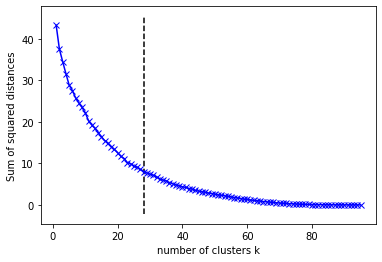

In [17]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 96)

for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k, random_state=0).fit(queretaro_grouped_clustering)
    kmeanModel.fit(queretaro_grouped_clustering)
 
    distortions.append(sum(np.min(cdist(queretaro_grouped_clustering, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / queretaro_grouped_clustering.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(queretaro_grouped_clustering, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / queretaro_grouped_clustering.shape[0]
    mapping2[k] = kmeanModel.inertia_
    
y = []
for key, val in mapping2.items():
    y.append(val)


x = range(1, len(y)+1)
from kneed import KneeLocator
kn = KneeLocator(x, y, curve='convex', direction='decreasing')
print(kn.knee)

plt.xlabel('number of clusters k')
plt.ylabel('Sum of squared distances')
plt.plot(x, y, 'bx-')
plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')

Then, I build the model and it returns the cluster label of each neighbourhood

In [18]:
kclusters = 28

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(queretaro_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:50] 

array([ 5,  0,  5,  5, 13,  3, 13, 11,  3,  7, 13, 17, 21,  5,  5,  6, 13,
        8, 13, 26,  1,  5, 13, 13,  9,  5, 13, 15,  7,  9, 23,  2, 26, 26,
        5, 10, 13,  3, 17,  3, 13, 13, 27, 13, 24, 13,  1, 14,  5,  5],
      dtype=int32)

Now I create a dataframe that contains the neighbourhood information, its most common venues and its cluster label.

In [19]:
#neighborhoods_venues_sorted = neighborhoods_venues_sorted.drop('Cluster Labels', 1)
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

queretaro_merged = neighbourhoods
queretaro_merged = queretaro_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')
queretaro_merged = queretaro_merged.dropna()
queretaro_merged.reset_index(inplace=True, drop=True)

queretaro_merged

,Borough,Neighbourhood,Longitude,Latitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Querétaro,Santiago de Querétaro,-100.39,20.5934,13.0,Mexican Restaurant,Plaza,Bar,Taco Place,Hotel,Restaurant,Museum,Café,Art Gallery,Italian Restaurant
1,Querétaro,Acequia Blanca,-100.468,20.7196,5.0,Farm,Lounge,Performing Arts Venue,Convenience Store,Recreation Center,Dive Bar,Farmers Market,Empanada Restaurant,Electronics Store,Donut Shop
2,Querétaro,Buenavista,-100.469,20.8216,13.0,Seafood Restaurant,Mexican Restaurant,Snack Place,BBQ Joint,Yoga Studio,Dive Bar,Farm,Empanada Restaurant,Electronics Store,Donut Shop
3,Querétaro,La Carbonera,-100.504,20.8065,7.0,Mexican Restaurant,Dive Bar,Fast Food Restaurant,Farmers Market,Farm,Empanada Restaurant,Electronics Store,Donut Shop,Dog Run,Yoga Studio
4,Querétaro,Casa Blanca,-100.506,20.752,11.0,Bar,Yoga Studio,Food & Drink Shop,Flower Shop,Fast Food Restaurant,Farmers Market,Farm,Empanada Restaurant,Electronics Store,Donut Shop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,Querétaro,Ejido San Miguelito 2,-100.501,20.7418,6.0,Amphitheater,Dive Bar,Fast Food Restaurant,Farmers Market,Farm,Empanada Restaurant,Electronics Store,Donut Shop,Dog Run,Diner
92,Querétaro,Tlacopan Rancho,-100.528,20.6627,3.0,Farm,Yoga Studio,Dive Bar,Fast Food Restaurant,Farmers Market,Empanada Restaurant,Electronics Store,Donut Shop,Dog Run,Diner
93,Querétaro,La Calavera,-100.458,20.7842,15.0,Italian Restaurant,Snack Place,Sandwich Place,Yoga Studio,Fast Food Restaurant,Farm,Empanada Restaurant,Electronics Store,Donut Shop,Dog Run
94,Querétaro,Los Pardas,-100.414,20.7846,24.0,Dog Run,Yoga Studio,Dive Bar,Fast Food Restaurant,Farmers Market,Farm,Empanada Restaurant,Electronics Store,Donut Shop,Diner


Finally I create a folium map that displays all the neighbourhoods and its respective cluster.

In [20]:
longitude = -100.39
latitude = 20.7
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(queretaro_merged['Latitude'], queretaro_merged['Longitude'], queretaro_merged['Neighbourhood'], queretaro_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(int(cluster) + 1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

I need to repeat the same process done in the data section with the Mexico City dataset to get the most common venues in Azacpotzalco.

In [21]:
residence_venues = getNearbyVenues(names=residence['Neighbourhood'],
                                   latitudes=residence['Latitude'],
                                   longitudes=residence['Longitude']
                                  )
residence_onehot = pd.get_dummies(residence_venues[['Venue Category']], prefix="", prefix_sep="")

residence_onehot['Neighborhood'] = residence_venues['Neighborhood'] 

fixed_columns = [residence_onehot.columns[-1]] + list(residence_onehot.columns[:-1])
residence_onehot = residence_onehot[fixed_columns]

residence_onehot.head()

residence_grouped = residence_onehot.groupby('Neighborhood').mean().reset_index()
residence_grouped

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
residence_merged = pd.DataFrame(columns=columns)
residence_merged['Neighborhood'] = residence_grouped['Neighborhood']

for ind in np.arange(residence_grouped.shape[0]):
    residence_merged.iloc[ind, 1:] = return_most_common_venues(residence_grouped.iloc[ind, :], num_top_venues)

residence_merged

Azcapotzalco


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Azcapotzalco,Mexican Restaurant,Taco Place,Bakery,Ice Cream Shop,Pizza Place,Breakfast Spot,Gym / Fitness Center,Gym,Steakhouse,Seafood Restaurant


This concludes our analysis. We have created 21 clusters representing areas with similar characteristics regarding common venues, this should be only considered as a help to determine a residence by looking which locations would you like to be near the most, there are lots of other factors that are also involved in determining a new address and that should be taken into account by skateholders.

Below here there is a display of the most common venues in the current residence and in each neighbourhood classified by cluster.

In [22]:
df_list = []
for i in range(0,28):
    dataframe = queretaro_merged.loc[queretaro_merged['Cluster Labels'] == i, queretaro_merged.columns[[1] + list(range(5, queretaro_merged.shape[1]))]]
    df_list.append(dataframe)
    
from IPython.display import display
j = 1
print('')
print('')
print('Residence')
display(residence_merged)
print('-----------------------------------------------------------------------------------------------------------------------------------------------------')
for i in df_list:
    print('')
    print('Cluster '+str(j))
    display(i)
    print('-----------------------------------------------------------------------------------------------------------------------------------------------------')
    j = j + 1



Residence


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Azcapotzalco,Mexican Restaurant,Taco Place,Bakery,Ice Cream Shop,Pizza Place,Breakfast Spot,Gym / Fitness Center,Gym,Steakhouse,Seafood Restaurant


-----------------------------------------------------------------------------------------------------------------------------------------------------

Cluster 1


,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
57,Santa María de los Reyes,Convenience Store,Soccer Field,Construction & Landscaping,Yoga Studio,Dog Run,Farmers Market,Farm,Empanada Restaurant,Electronics Store,Donut Shop
79,Acueducto,Gym,Convenience Store,Bakery,Yoga Studio,Dog Run,Fast Food Restaurant,Farmers Market,Farm,Empanada Restaurant,Electronics Store


-----------------------------------------------------------------------------------------------------------------------------------------------------

Cluster 2


,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Mompaní,Mexican Restaurant,Plaza,Molecular Gastronomy Restaurant,Caribbean Restaurant,Yoga Studio,Dive Bar,Farm,Empanada Restaurant,Electronics Store,Donut Shop
17,El Puertecito,History Museum,Caribbean Restaurant,Yoga Studio,Dive Bar,Fast Food Restaurant,Farmers Market,Farm,Empanada Restaurant,Electronics Store,Donut Shop
47,Quinta Mompaní,Mexican Restaurant,Caribbean Restaurant,Dive Bar,Fast Food Restaurant,Farmers Market,Farm,Empanada Restaurant,Electronics Store,Donut Shop,Dog Run


-----------------------------------------------------------------------------------------------------------------------------------------------------

Cluster 3


,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,Pintillo,Taco Place,Yoga Studio,Dive Bar,Fast Food Restaurant,Farmers Market,Farm,Empanada Restaurant,Electronics Store,Donut Shop,Dog Run
78,Rancho la Tinaja,Taco Place,Yoga Studio,Dive Bar,Fast Food Restaurant,Farmers Market,Farm,Empanada Restaurant,Electronics Store,Donut Shop,Dog Run
95,La Lomita,Taco Place,Yoga Studio,Dive Bar,Fast Food Restaurant,Farmers Market,Farm,Empanada Restaurant,Electronics Store,Donut Shop,Dog Run


-----------------------------------------------------------------------------------------------------------------------------------------------------

Cluster 4


,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
44,Cañada de la Monja,Farm,Yoga Studio,Dive Bar,Fast Food Restaurant,Farmers Market,Empanada Restaurant,Electronics Store,Donut Shop,Dog Run,Diner
46,Las Mariposas,Farm,Yoga Studio,Dive Bar,Fast Food Restaurant,Farmers Market,Empanada Restaurant,Electronics Store,Donut Shop,Dog Run,Diner
67,Arroyo de los Tepetates,Farm,Yoga Studio,Dive Bar,Fast Food Restaurant,Farmers Market,Empanada Restaurant,Electronics Store,Donut Shop,Dog Run,Diner
69,Las Paulonias [Fraccionamiento Campestre],Farm,Yoga Studio,Dive Bar,Fast Food Restaurant,Farmers Market,Empanada Restaurant,Electronics Store,Donut Shop,Dog Run,Diner
73,Quinta los Corrales,Farm,Yoga Studio,Dive Bar,Fast Food Restaurant,Farmers Market,Empanada Restaurant,Electronics Store,Donut Shop,Dog Run,Diner
92,Tlacopan Rancho,Farm,Yoga Studio,Dive Bar,Fast Food Restaurant,Farmers Market,Empanada Restaurant,Electronics Store,Donut Shop,Dog Run,Diner


-----------------------------------------------------------------------------------------------------------------------------------------------------

Cluster 5


,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
74,Rancho el Álamo,Lake,Yoga Studio,Food,Fast Food Restaurant,Farmers Market,Farm,Empanada Restaurant,Electronics Store,Donut Shop,Dog Run
86,Rancho Naranjo,Lake,Yoga Studio,Food,Fast Food Restaurant,Farmers Market,Farm,Empanada Restaurant,Electronics Store,Donut Shop,Dog Run
87,Tierras Duras,Lake,Yoga Studio,Food,Fast Food Restaurant,Farmers Market,Farm,Empanada Restaurant,Electronics Store,Donut Shop,Dog Run


-----------------------------------------------------------------------------------------------------------------------------------------------------

Cluster 6


,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Acequia Blanca,Farm,Lounge,Performing Arts Venue,Convenience Store,Recreation Center,Dive Bar,Farmers Market,Empanada Restaurant,Electronics Store,Donut Shop
7,San Francisco de la Palma,Recreation Center,Plaza,Food Court,Garden,Soccer Stadium,Comfort Food Restaurant,Dive Bar,Farm,Empanada Restaurant,Electronics Store
9,Juriquilla,Taco Place,Restaurant,Italian Restaurant,Pool,Grocery Store,Park,Coffee Shop,Performing Arts Venue,Golf Course,Department Store
18,Puerto de Aguirre,Soccer Field,Coffee Shop,Athletics & Sports,Food Truck,Deli / Bodega,Dog Run,Fast Food Restaurant,Farmers Market,Farm,Empanada Restaurant
19,La Purísima,Restaurant,Ice Cream Shop,Clothing Store,Department Store,Electronics Store,Burger Joint,Coffee Shop,Chocolate Shop,Food Court,Multiplex
21,El Refugio,Wings Joint,Convenience Store,Burger Joint,Diner,Taco Place,Supermarket,Grocery Store,Cupcake Shop,Deli / Bodega,Construction & Landscaping
26,San José Buenavista,Lounge,History Museum,Sandwich Place,Yoga Studio,Dive Bar,Farmers Market,Farm,Empanada Restaurant,Electronics Store,Donut Shop
29,San Pedro Mártir,Soccer Field,Gym,Mexican Restaurant,Park,Diner,Farm,Empanada Restaurant,Electronics Store,Donut Shop,Dog Run
31,Santa María Magdalena,Soccer Field,Convenience Store,Soccer Stadium,Italian Restaurant,Park,Athletics & Sports,Food Court,Taco Place,Bakery,Farmers Market
33,Santo Niño de Praga,Farm,Playground,Plaza,Food Court,Soccer Stadium,Yoga Studio,Diner,Empanada Restaurant,Electronics Store,Donut Shop


-----------------------------------------------------------------------------------------------------------------------------------------------------

Cluster 7


,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
28,San Miguelito,Amphitheater,Dive Bar,Fast Food Restaurant,Farmers Market,Farm,Empanada Restaurant,Electronics Store,Donut Shop,Dog Run,Diner
91,Ejido San Miguelito 2,Amphitheater,Dive Bar,Fast Food Restaurant,Farmers Market,Farm,Empanada Restaurant,Electronics Store,Donut Shop,Dog Run,Diner


-----------------------------------------------------------------------------------------------------------------------------------------------------

Cluster 8


,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,La Carbonera,Mexican Restaurant,Dive Bar,Fast Food Restaurant,Farmers Market,Farm,Empanada Restaurant,Electronics Store,Donut Shop,Dog Run,Yoga Studio
5,Cerro de la Cruz,Mexican Restaurant,Dive Bar,Fast Food Restaurant,Farmers Market,Farm,Empanada Restaurant,Electronics Store,Donut Shop,Dog Run,Yoga Studio
35,Tlacote el Alto,Mexican Restaurant,Dive Bar,Fast Food Restaurant,Farmers Market,Farm,Empanada Restaurant,Electronics Store,Donut Shop,Dog Run,Yoga Studio
56,Santa Juanita,Mexican Restaurant,BBQ Joint,Yoga Studio,Dog Run,Fast Food Restaurant,Farmers Market,Farm,Empanada Restaurant,Electronics Store,Donut Shop


-----------------------------------------------------------------------------------------------------------------------------------------------------

Cluster 9


,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,El Nabo,Gym / Fitness Center,Dog Run,Yoga Studio,Dive Bar,Fast Food Restaurant,Farmers Market,Farm,Empanada Restaurant,Electronics Store,Donut Shop


-----------------------------------------------------------------------------------------------------------------------------------------------------

Cluster 10


,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Jofrito,Food Truck,Motel,Hotel,Yoga Studio,Dog Run,Farmers Market,Farm,Empanada Restaurant,Electronics Store,Donut Shop
51,La Casita,Food Truck,Motel,Hotel,Yoga Studio,Dog Run,Farmers Market,Farm,Empanada Restaurant,Electronics Store,Donut Shop


-----------------------------------------------------------------------------------------------------------------------------------------------------

Cluster 11


,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
34,La Solana,Stadium,Yoga Studio,Food,Fast Food Restaurant,Farmers Market,Farm,Empanada Restaurant,Electronics Store,Donut Shop,Dog Run


-----------------------------------------------------------------------------------------------------------------------------------------------------

Cluster 12


,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Casa Blanca,Bar,Yoga Studio,Food & Drink Shop,Flower Shop,Fast Food Restaurant,Farmers Market,Farm,Empanada Restaurant,Electronics Store,Donut Shop
75,Rancho el Mesón,Bar,Yoga Studio,Food & Drink Shop,Flower Shop,Fast Food Restaurant,Farmers Market,Farm,Empanada Restaurant,Electronics Store,Donut Shop


-----------------------------------------------------------------------------------------------------------------------------------------------------

Cluster 13


,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
49,Rancho Santa Mónica,Historic Site,Yoga Studio,Dive Bar,Fast Food Restaurant,Farmers Market,Farm,Empanada Restaurant,Electronics Store,Donut Shop,Dog Run


-----------------------------------------------------------------------------------------------------------------------------------------------------

Cluster 14


,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Santiago de Querétaro,Mexican Restaurant,Plaza,Bar,Taco Place,Hotel,Restaurant,Museum,Café,Art Gallery,Italian Restaurant
2,Buenavista,Seafood Restaurant,Mexican Restaurant,Snack Place,BBQ Joint,Yoga Studio,Dive Bar,Farm,Empanada Restaurant,Electronics Store,Donut Shop
20,Rancho Largo,Seafood Restaurant,Mexican Restaurant,Taco Place,Restaurant,Coffee Shop,Bar,Liquor Store,Diner,BBQ Joint,Shopping Mall
23,El Salitre,Restaurant,Athletics & Sports,Food Truck,Hotel,Taco Place,Sports Club,Stadium,Yoga Studio,Dog Run,Farm
27,San José el Alto,Seafood Restaurant,Taco Place,Mexican Restaurant,Convenience Store,Yoga Studio,Dive Bar,Farm,Empanada Restaurant,Electronics Store,Donut Shop
32,Santa Rosa Jáuregui,Mexican Restaurant,Taco Place,Playground,Park,Track Stadium,Restaurant,Soccer Field,Tattoo Parlor,Athletics & Sports,Market
40,Los Arquitos,Snack Place,Convenience Store,Hotel,Taco Place,Business Service,Dive Bar,Farmers Market,Farm,Empanada Restaurant,Electronics Store
41,La Azteca,Hotel,Mexican Restaurant,Yoga Studio,Wings Joint,Pharmacy,Restaurant,Burger Joint,Shopping Mall,Breakfast Spot,Seafood Restaurant
48,Colinas de Santa Cruz Segunda Sección,Pharmacy,Mexican Restaurant,Taco Place,Convenience Store,Park,Pizza Place,Big Box Store,Gym,Bagel Shop,BBQ Joint
50,El Huizachal de las Tetillas,Seafood Restaurant,Mexican Restaurant,Convenience Store,Athletics & Sports,Spa,Juice Bar,Gym / Fitness Center,Vegetarian / Vegan Restaurant,Pet Café,Tennis Court


-----------------------------------------------------------------------------------------------------------------------------------------------------

Cluster 15


,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Montenegro,Park,Yoga Studio,Diner,Farmers Market,Farm,Empanada Restaurant,Electronics Store,Donut Shop,Dog Run,Dive Bar
15,Pinto,Park,Taco Place,Yoga Studio,Diner,Farmers Market,Farm,Empanada Restaurant,Electronics Store,Donut Shop,Dog Run
25,San Isidro el Viejo,Burger Joint,Park,Yoga Studio,Dive Bar,Farmers Market,Farm,Empanada Restaurant,Electronics Store,Donut Shop,Dog Run
59,Rancho la Curva,Amphitheater,Burger Joint,Park,Dive Bar,Farmers Market,Farm,Empanada Restaurant,Electronics Store,Donut Shop,Dog Run


-----------------------------------------------------------------------------------------------------------------------------------------------------

Cluster 16


,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
24,San Isidro Buenavista,Snack Place,Lake,Sandwich Place,Italian Restaurant,Dog Run,Farmers Market,Farm,Empanada Restaurant,Electronics Store,Donut Shop
93,La Calavera,Italian Restaurant,Snack Place,Sandwich Place,Yoga Studio,Fast Food Restaurant,Farm,Empanada Restaurant,Electronics Store,Donut Shop,Dog Run


-----------------------------------------------------------------------------------------------------------------------------------------------------

Cluster 17


,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
43,Rancho de Guadalupe (La Lágrima),Stables,Yoga Studio,Food,Fast Food Restaurant,Farmers Market,Farm,Empanada Restaurant,Electronics Store,Donut Shop,Dog Run


-----------------------------------------------------------------------------------------------------------------------------------------------------

Cluster 18


,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,Corea,Lounge,Gastropub,Lake,Mexican Restaurant,Convenience Store,Cupcake Shop,Deli / Bodega,Department Store,Construction & Landscaping,Diner
85,Las Naranjo,Farm,Lake,Yoga Studio,Food,Fast Food Restaurant,Farmers Market,Empanada Restaurant,Electronics Store,Donut Shop,Dog Run
90,Parque Opción [Parque Industrial],Lake,Lounge,Mexican Restaurant,Food,Fast Food Restaurant,Farmers Market,Farm,Empanada Restaurant,Electronics Store,Donut Shop


-----------------------------------------------------------------------------------------------------------------------------------------------------

Cluster 19


,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
58,Prados de Miranda,Amphitheater,Speakeasy,Theater,Food Truck,Dive Bar,Farmers Market,Farm,Empanada Restaurant,Electronics Store,Donut Shop


-----------------------------------------------------------------------------------------------------------------------------------------------------

Cluster 20


,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
39,San Pedrito el Alto (El Obraje),Campground,Yoga Studio,Dive Bar,Fast Food Restaurant,Farmers Market,Farm,Empanada Restaurant,Electronics Store,Donut Shop,Dog Run


-----------------------------------------------------------------------------------------------------------------------------------------------------

Cluster 21


,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,Rancho el Rincón,Burger Joint,Farmers Market,Yoga Studio,Dog Run,Fast Food Restaurant,Farm,Empanada Restaurant,Electronics Store,Donut Shop,Dive Bar


-----------------------------------------------------------------------------------------------------------------------------------------------------

Cluster 22


,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
81,Cuatro Milpas,Speakeasy,Yoga Studio,Food,Fast Food Restaurant,Farmers Market,Farm,Empanada Restaurant,Electronics Store,Donut Shop,Dog Run


-----------------------------------------------------------------------------------------------------------------------------------------------------

Cluster 23


,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,Santa María del Zapote,Brewery,Yoga Studio,Dog Run,Flower Shop,Fast Food Restaurant,Farmers Market,Farm,Empanada Restaurant,Electronics Store,Donut Shop


-----------------------------------------------------------------------------------------------------------------------------------------------------

Cluster 24


,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,La Estacada,Food Truck,Yoga Studio,Food,Fast Food Restaurant,Farmers Market,Farm,Empanada Restaurant,Electronics Store,Donut Shop,Dog Run


-----------------------------------------------------------------------------------------------------------------------------------------------------

Cluster 25


,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
94,Los Pardas,Dog Run,Yoga Studio,Dive Bar,Fast Food Restaurant,Farmers Market,Farm,Empanada Restaurant,Electronics Store,Donut Shop,Diner


-----------------------------------------------------------------------------------------------------------------------------------------------------

Cluster 26


,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
30,Santa Catarina,City,Sandwich Place,Snack Place,Mexican Restaurant,Comfort Food Restaurant,Construction & Landscaping,Convenience Store,Cupcake Shop,Deli / Bodega,Department Store
54,Santa Catarina [Asociación de Colonos],Mexican Restaurant,Sandwich Place,Snack Place,City,Garden,Dog Run,Cocktail Bar,Farm,Empanada Restaurant,Electronics Store
60,Rancho Quinta Diana,City,Sandwich Place,Snack Place,Mexican Restaurant,Comfort Food Restaurant,Construction & Landscaping,Convenience Store,Cupcake Shop,Deli / Bodega,Department Store


-----------------------------------------------------------------------------------------------------------------------------------------------------

Cluster 27


,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,La Monja,Farm,Garden,Yoga Studio,Food,Fast Food Restaurant,Farmers Market,Empanada Restaurant,Electronics Store,Donut Shop,Dog Run
45,Rancho la Aldea,Garden,City,Farm,Mexican Restaurant,Construction & Landscaping,Convenience Store,Cupcake Shop,Deli / Bodega,Department Store,Diner
65,La Nueva Palma,Gun Range,Garden,Yoga Studio,Dive Bar,Farmers Market,Farm,Empanada Restaurant,Electronics Store,Donut Shop,Dog Run
70,El Plan,Farm,Garden,Yoga Studio,Food,Fast Food Restaurant,Farmers Market,Empanada Restaurant,Electronics Store,Donut Shop,Dog Run


-----------------------------------------------------------------------------------------------------------------------------------------------------

Cluster 28


,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
72,Los Cuates,Shopping Mall,Yoga Studio,Dive Bar,Farmers Market,Farm,Empanada Restaurant,Electronics Store,Donut Shop,Dog Run,Diner


-----------------------------------------------------------------------------------------------------------------------------------------------------


## Results and Discussion <a name="results"></a>

Our analysis shows that although there is an enormous variety of different venues in Queretaro, Queretaro (which has an area of 740.93km2), they can be segmented by neighbourhood easily. The biggest cluster is in the center of the city because it is the most popular area of the state so the neighbourhoods are very similar an the rest of them are smallers and distributed along the borders.

Result of all this is 28 areas that share common venues and that are potential new homes based on their similarity with the current neighbourhood or the preferences of the skateholder. This, of course, does not imply that this is the only factor to take into account. The purpose of this analysis was just to provide info on the common venues of each neighbourhood in Queretaro, Queretaro - hence, this should only be taken as a starting point for making more research about the areas and the requirements that need to be met by the neighbourhoods according to the skateholders.

## Conclusion <a name="conclusion"></a>

Purpose of this project was to segment neighbourhoods according to the most common venues found there in order to aid skateholders in making easier the search for a new residence so they can move. By calculating the most common venues making use of the Foursquare location data, we have first identified the frecuency of venues for each neighbourhood, and then segmented the neighbourhoods into some clusters which items satify the characteritic of sharig similarities. Displaying of those clusters was then performed in order to have a better idea of its geographical distribution and a comparison with the characteritics of the skateholders neighbourhood was done so that an exploration can be done by the skateholders.

Final decision on new address will be made by skateholders based on their preferences of characteristics of neighborhoods and locations in every area, taking into consideration additional factors that like attractiveness of each location, levels of noise / proximity to major roads, real estate availability, prices, social and economic dynamics of every neighborhood etc.